In [1]:
# SETUP AND IMPORTS
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings
import sys
import os

# --- PyTorch and Sklearn Imports --
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import average_precision_score
from tqdm.notebook import tqdm
from einops import rearrange

# --- TensorFlow for Data Loading ONLY --
import tensorflow as tf

# --- CRITICAL FIX v2: Isolate TensorFlow to CPU without hiding the GPU from PyTorch ---
try:
    physical_devices = tf.config.list_physical_devices()
    cpus = [d for d in physical_devices if d.device_type == 'CPU']
    tf.config.set_visible_devices(cpus)
    print("✅ TensorFlow successfully configured to use CPU only.")

    # --- VERIFICATION STEP ---
    if not tf.config.list_physical_devices('GPU'):
        print("   - Confirmed: TensorFlow does not see the GPU.")
    else:
        print("   - ⚠️ WARNING: TensorFlow can still see the GPU. Conflicts may occur.")

    if torch.cuda.is_available():
        print("✅ PyTorch can see and use the GPU.")
        print(f"   - GPU Device Name: {torch.cuda.get_device_name(0)}")
    else:
        print("   - ❌ CRITICAL WARNING: PyTorch cannot see the GPU. Training will be on CPU.")

except Exception as e:
    print(f"An error occurred during device configuration: {e}")


warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Define data directory
DATA_DIR = Path("/kaggle/input/ndws_western_dataset")
print(f"📁 Data directory: {DATA_DIR}")
print(f"📂 Directory exists: {DATA_DIR.exists()}")

# --- CORRECTED TFRecord PARSING FUNCTION --
def parse_tfrecord_flexible(example):
    """
    Parse TFRecord with the CORRECT feature description.
    """
    feature_description = {}

    expected_features = [
        'elevation', 'NDVI', 'erc', 'pr', 'pdsi', 'population',
        'impervious', 'water', 'tmp_day', 'tmp_75', 'wind_avg', 'wind_75',
        'wdir_wind', 'wdir_gust', 'gust_med', 'avg_sph', 'bi', 'chili',
        'fuel1', 'fuel2', 'fuel3', 'viirs_PrevFireMask', 'viirs_FireMask'
    ]

    for feat in expected_features:
        feature_description[feat] = tf.io.FixedLenFeature([64, 64], tf.float32)

    parsed_features = tf.io.parse_single_example(example, feature_description)
    return parsed_features

print("\n✅ Setup complete!")

2025-10-10 17:32:58.541808: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760117578.731557      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760117578.787139      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ TensorFlow successfully configured to use CPU only.
   - ⚠️ WARNING: TensorFlow can still see the GPU. Conflicts may occur.
✅ PyTorch can see and use the GPU.
   - GPU Device Name: Tesla P100-PCIE-16GB
📁 Data directory: /kaggle/input/ndws_western_dataset
📂 Directory exists: True

✅ Setup complete!


In [2]:
# --- UPDATED VISUALIZATION FUNCTION (WITH SAVE CAPABILITY) ---

def visualize_fire_predictions_pytorch(model, X_test, y_test, num_samples=4, save_path=None):
    """
    Visualize fire prediction results and optionally save the plot to a file.
    """
    if len(X_test) == 0:
        print("❌ No test samples available for visualization")
        return

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    X_test_subset = X_test[:num_samples]
    y_test_subset = y_test[:num_samples]

    with torch.no_grad():
        X_test_tensor = torch.from_numpy(np.transpose(X_test_subset, (0, 3, 1, 2))).float().to(device)
        predictions_tensor = model(X_test_tensor)
        predictions = np.transpose(predictions_tensor.cpu().numpy(), (0, 2, 3, 1))

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        input_fire = X_test_subset[i, :, :, 0]
        true_fire = y_test_subset[i, :, :, 0]
        pred_fire = predictions[i, :, :, 0]

        axes[i, 0].imshow(input_fire, cmap='Reds', vmin=0, vmax=1)
        axes[i, 0].set_title(f'Sample {i+1}: Input Fire (t)')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(true_fire, cmap='Reds', vmin=0, vmax=1)
        axes[i, 1].set_title(f'True Fire (t+1)')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_fire, cmap='Reds', vmin=0, vmax=1)
        axes[i, 2].set_title(f'Predicted Fire (t+1)')
        axes[i, 2].axis('off')

    plt.tight_layout()

    # <<< NEW: Save the figure if a path is provided >>>
    if save_path:
        try:
            plt.savefig(save_path, bbox_inches='tight', dpi=150)
            print(f"✅ Visualization saved to '{save_path}'")
        except Exception as e:
            print(f"⚠️ Could not save visualization. Error: {e}")

    plt.show() # Display the plot after saving

    # Return the prediction statistics so they can be saved to the results file
    stats = {
        "true_fire_pixels": np.sum(y_test_subset > 0.1),
        "predicted_fire_pixels": np.sum(predictions > 0.5),
        "average_prediction_confidence": np.mean(predictions)
    }

    # Print statistics to the notebook
    print(f"\n📊 PREDICTION STATISTICS:")
    print(f"🔥 True fire pixels in displayed samples: {stats['true_fire_pixels']}")
    print(f"🎯 Predicted fire pixels (threshold > 0.5): {stats['predicted_fire_pixels']}")
    print(f"📈 Average prediction confidence: {stats['average_prediction_confidence']:.4f}")

    return stats

# --- NEW FUNCTION TO SAVE ALL RESULTS TO A TEXT FILE ---
def save_results_to_file(model_name, cv_results, viz_stats, file_path="model_results.txt"):
    """
    Saves the cross-validation and visualization statistics for a model to a text file.
    """
    mean_ap = np.mean(cv_results)
    std_ap = np.std(cv_results)

    try:
        with open(file_path, 'a') as f: # 'a' for append mode
            f.write("="*70 + "\n")
            f.write(f"MODEL: {model_name}\n")
            f.write("="*70 + "\n\n")

            f.write("--- Cross-Validation Summary ---\n")
            f.write(f"Mean Average Precision (AP): {mean_ap:.4f} ± {std_ap:.4f}\n")
            f.write(f"Individual Fold AP Scores: {[f'{score:.4f}' for score in cv_results]}\n\n")

            if viz_stats:
                f.write("--- Visualization Sample Statistics ---\n")
                f.write(f"True Fire Pixels: {viz_stats['true_fire_pixels']}\n")
                f.write(f"Predicted Fire Pixels (>0.5): {viz_stats['predicted_fire_pixels']}\n")
                f.write(f"Average Prediction Confidence: {viz_stats['average_prediction_confidence']:.4f}\n\n\n")

        print(f"✅ Results for '{model_name}' appended to '{file_path}'")
    except Exception as e:
        print(f"⚠️ Could not save results to file. Error: {e}")

print("✅ Visualization and results-saving functions are ready!")

✅ Visualization and results-saving functions are ready!


# 🔥 SPATIAL FIRE SPREAD PREDICTION WITH TransUNet ARCHITECTURE

**CRITICAL FIX**: This section implements proper spatial fire spread prediction using:
- ✅ **Raw spatial features** (64x64 grids) - NOT statistical summaries
- ✅ **All 106 input features** as spatial inputs
- ✅ **TransUNet architecture** for pixel-level fire spread prediction
- ✅ **Temporal prediction**: PrevFireMask(t) → FireMask(t+1)
- ✅ **Research-based approach** following wildfire prediction literature

**Key Point**: The data pipeline remains identical to the U-Net and Attention U-Net versions. The core change is the model architecture, which now combines a CNN encoder with a Transformer for enhanced global context.

In [3]:
# --- FINAL DATA PROCESSOR: COMBINING TIME-SERIES AND CURRENT DAY DATA ---

class CombinedFireDataProcessor:
    """
    Processes data to give the model the best of both worlds:
    - Historical environmental context (from the past)
    - Current day fire and environmental state
    """
    def __init__(self, data_dir=DATA_DIR, num_timesteps=4):
        self.data_dir = data_dir
        self.num_timesteps = num_timesteps # Past days of environmental data
        self.environmental_features = [
            'elevation', 'NDVI', 'erc', 'pr', 'pdsi', 'population',
            'impervious', 'water', 'tmp_day', 'tmp_75', 'wind_avg', 'wind_75',
            'wdir_wind', 'wdir_gust', 'gust_med', 'avg_sph', 'bi', 'chili',
            'fuel1', 'fuel2', 'fuel3'
        ]

    def load_raw_spatial_data(self, max_sequences=None):
        """
        Load and create the ultimate time-series sequences.
        Input X: viirs_PrevFireMask(t) + Env Features(t-4 to t-1) + Env Features(t)
        Target Y: viirs_FireMask(t+1)
        """
        print("🔥 Loading RAW SPATIAL DATA for COMBINED (Time-Series + Current Day) prediction...")
        
        tfrecord_files = list(self.data_dir.glob("*.tfrecord"))
        if not tfrecord_files:
            print("❌ No TFRecord files found!")
            return None, None
        print(f"📁 Found {len(tfrecord_files)} TFRecord files")

        all_samples_flat = []
        # Load all daily snapshots into one list
        for file_path in tfrecord_files:
            dataset = tf.data.TFRecordDataset(str(file_path))
            for raw_record in dataset:
                try:
                    parsed_sample = parse_tfrecord_flexible(raw_record)
                    sample_data = {name: tensor.numpy() for name, tensor in parsed_sample.items()}
                    if 'viirs_PrevFireMask' in sample_data and 'viirs_FireMask' in sample_data:
                        all_samples_flat.append(sample_data)
                except Exception as e:
                    print(f"❗️ FAILED TO PROCESS A RECORD in {file_path.name}. Error: {e}")
                    break
            else: continue
            break
        
        print(f"  ...Loaded {len(all_samples_flat)} total individual samples.")

        if not all_samples_flat:
             print("❌ No valid samples were loaded.")
             return None, None

        # --- COMBINED SLIDING WINDOW LOGIC ---
        spatial_inputs, spatial_targets = [], []
        # Total window size = num_timesteps (past env) + 1 (current day) + 1 (target day)
        sequence_len = self.num_timesteps + 2
        
        for i in range(len(all_samples_flat) - sequence_len):
            if max_sequences and len(spatial_inputs) >= max_sequences:
                break

            # Define the time windows
            past_environmental_sequence = all_samples_flat[i : i + self.num_timesteps] # t-4 to t-1
            current_day_sample = all_samples_flat[i + self.num_timesteps]              # day 't'
            next_day_sample = all_samples_flat[i + self.num_timesteps + 1]           # day 't+1'

            # --- Assemble the Input Tensor (X) ---
            input_features = []
            
            # 1. Add the fire mask from the CURRENT day (t)
            input_features.append(current_day_sample['viirs_PrevFireMask'].reshape(64, 64, 1))

            # 2. Add environmental features from the PAST days (t-4 to t-1)
            for past_sample in past_environmental_sequence:
                for feature_name in self.environmental_features:
                    if feature_name in past_sample:
                        input_features.append(past_sample[feature_name].reshape(64, 64, 1))
            
            # 3. Add environmental features from the CURRENT day (t)
            for feature_name in self.environmental_features:
                 if feature_name in current_day_sample:
                    input_features.append(current_day_sample[feature_name].reshape(64, 64, 1))

            # --- Assemble the Target Tensor (y) ---
            target_mask = next_day_sample['viirs_FireMask'].reshape(64, 64, 1)

            if len(input_features) > 1:
                spatial_inputs.append(np.concatenate(input_features, axis=2))
                spatial_targets.append(target_mask)

        if not spatial_inputs:
            print("❌ Could not create any sequences with the combined logic!")
            return None, None
            
        X_spatial = np.array(spatial_inputs, dtype=np.float32)
        y_spatial = np.array(spatial_targets, dtype=np.float32)

        print(f"\n✅ COMBINED DATA LOADING COMPLETE")
        print(f"📊 Spatial Input Shape: {X_spatial.shape}")
        print(f"📊 Spatial Target Shape: {y_spatial.shape}")
        return X_spatial, y_spatial

In [4]:
# --- DATASET CLASS AND NORMALIZATION (UNCHANGED FROM PREVIOUS NOTEBOOKS) ---
import random
from torch.utils.data import Dataset, SubsetRandomSampler

class WildfireDataset(Dataset):
    """
    PyTorch Dataset for loading wildfire sequences "just-in-time" from TFRecords.
    This avoids loading the entire dataset into memory.
    """
    def __init__(self, data_dir, num_timesteps=4, max_sequences=None, normalization_stats=None):
        self.data_dir = data_dir
        self.num_timesteps = num_timesteps
        self.normalization_stats = normalization_stats
        self.sequence_len = self.num_timesteps + 2 # Total daily records needed for one sequence

        self.environmental_features = [
            'elevation', 'NDVI', 'erc', 'pr', 'pdsi', 'population', 'impervious', 'water',
            'tmp_day', 'tmp_75', 'wind_avg', 'wind_75', 'wdir_wind', 'wdir_gust', 'gust_med',
            'avg_sph', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3'
        ]

        print("🔥 Initializing WildfireDataset: Building sequence index...")
        self.tfrecord_files = sorted(list(self.data_dir.glob("*.tfrecord")))
        self.index = self._build_index()

        if max_sequences is not None and max_sequences < len(self.index):
            print(f" M Randomly sampling {max_sequences} sequences from the full dataset.")
            self.index = random.sample(self.index, max_sequences)

        print(f"✅ Index created. Dataset contains {len(self.index)} sequences.")

    def _build_index(self):
        """ Scans TFRecords and creates a master list of all valid sequence start points. """
        index = []
        for file_path in self.tfrecord_files:
            # Get the total number of records in the file quickly
            num_records = sum(1 for _ in tf.data.TFRecordDataset(str(file_path)))

            # A sequence can start at 'i' if there are enough records after it
            for i in range(num_records - self.sequence_len + 1):
                index.append((str(file_path), i)) # Store (filepath, record_offset)
        return index

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        """ Loads and processes a single sequence from disk on demand. """
        file_path, record_offset = self.index[idx]

        # Use tf.data to efficiently skip to the required records
        dataset = tf.data.TFRecordDataset(file_path)
        raw_records = dataset.skip(record_offset).take(self.sequence_len)

        # Load the small set of daily samples needed for this one sequence
        daily_samples = []
        for raw_record in raw_records:
            parsed_sample = parse_tfrecord_flexible(raw_record)
            sample_data = {name: tensor.numpy() for name, tensor in parsed_sample.items()}
            daily_samples.append(sample_data)

        # --- Assemble the Input and Target Tensors (same logic as before) ---
        past_environmental_sequence = daily_samples[0 : self.num_timesteps]
        current_day_sample = daily_samples[self.num_timesteps]
        next_day_sample = daily_samples[self.num_timesteps + 1]

        input_features = []
        # 1. Current fire mask
        input_features.append(current_day_sample['viirs_PrevFireMask'].reshape(64, 64, 1))
        # 2. Past environmental features (4 days * 21 features = 84 channels)
        for past_sample in past_environmental_sequence:
            for feature_name in self.environmental_features:
                if feature_name in past_sample:
                    input_features.append(past_sample[feature_name].reshape(64, 64, 1))
        # 3. Current environmental features (21 features)
        for feature_name in self.environmental_features:
             if feature_name in current_day_sample:
                input_features.append(current_day_sample[feature_name].reshape(64, 64, 1))
        
        # Total Input Channels = 1 (fire) + 4*21 (past env) + 21 (current env) = 106 channels

        # Concatenate and transpose for PyTorch (C, H, W)
        x = np.concatenate(input_features, axis=2).astype(np.float32)
        x = np.transpose(x, (2, 0, 1))

        # Get target mask and transpose
        y = next_day_sample['viirs_FireMask'].reshape(64, 64, 1).astype(np.float32)
        y = (np.transpose(y, (2, 0, 1)) > 0.1).astype(np.float32)

        x_tensor = torch.from_numpy(x)
        y_tensor = torch.from_numpy(y)

        # Apply normalization if stats are provided
        if self.normalization_stats is not None:
            means = self.normalization_stats['means']
            stds = self.normalization_stats['stds']
            x_tensor = (x_tensor - means) / stds

        return x_tensor, y_tensor

def calculate_normalization_stats(dataset, num_samples=500):
    """ Calculates mean and std for normalization on a subset of the data. """
    print(f"📊 Calculating normalization statistics on {num_samples} random samples...")

    # Ensure we don't request more samples than available
    num_samples = min(num_samples, len(dataset))

    # Create a temporary loader to get a random subset of data
    sampler = SubsetRandomSampler(random.sample(range(len(dataset)), num_samples))
    loader = DataLoader(dataset, batch_size=32, sampler=sampler, num_workers=2) # Increased batch size for speed

    # Use a running computation for mean and std
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for inputs, _ in tqdm(loader, desc="Calculating Stats"):
        # inputs shape is (B, C, H, W)
        channels_sum += torch.mean(inputs, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(inputs**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5
    std[std == 0] = 1 # Avoid division by zero

    # Reshape to (C, 1, 1) for broadcasting during normalization
    stats = {
        'means': mean.reshape(-1, 1, 1),
        'stds': std.reshape(-1, 1, 1)
    }
    print("✅ Normalization stats calculated.")
    return stats

In [5]:
# --- PYTORCH TRANSUNET ARCHITECTURE (CORRECTED), LOSS, AND TRAINING FUNCTION ---

# --- HELPER MODULES FOR TRANSFORMER ---
from einops import rearrange

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )
    def forward(self, x):
        return self.net(x)

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_dim, qkv_bias=False):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = FeedForward(dim, mlp_dim)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# --- CONV BLOCK HELPER FOR U-NET PARTS ---
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

# --- CORRECTED TRANSUNET MODEL ---
class TransUNet(nn.Module):
    def __init__(self, in_channels=106, out_channels=1, init_features=32,
                 vit_patch_size=1, vit_dim=512, vit_depth=4, vit_heads=8, vit_mlp_dim=1024):
        super(TransUNet, self).__init__()

        self.init_features = init_features
        self.vit_dim = vit_dim
        self.patch_size = vit_patch_size

        # --- CNN ENCODER ---
        self.encoder1 = conv_block(in_channels, init_features)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = conv_block(init_features, init_features * 2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = conv_block(init_features * 2, init_features * 4)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Bottleneck feature map before transformer
        self.encoder4 = conv_block(init_features * 4, init_features * 8)
        
        # --- TRANSFORMER ---
        # The input to the transformer is the output of encoder4, which is (B, 256, 8, 8)
        # We treat each 1x1 spatial location as a "patch".
        vit_num_patches = (8 // vit_patch_size) ** 2
        vit_patch_dim = (init_features * 8) * (vit_patch_size ** 2)
        
        self.vit_projection = nn.Linear(vit_patch_dim, vit_dim)
        self.vit_pos_embed = nn.Parameter(torch.randn(1, vit_num_patches, vit_dim))
        self.transformer = nn.Sequential(
            *[TransformerBlock(dim=vit_dim, num_heads=vit_heads, mlp_dim=vit_mlp_dim) for _ in range(vit_depth)]
        )
        
        # --- CNN DECODER ---
        # **CORRECTION**: The first up-convolution takes the transformer's output dimension as input.
        self.upconv3 = nn.ConvTranspose2d(vit_dim, init_features * 4, kernel_size=2, stride=2)
        self.decoder3 = conv_block(init_features * 8, init_features * 4) # Channels are doubled by skip connection
        
        self.upconv2 = nn.ConvTranspose2d(init_features * 4, init_features * 2, kernel_size=2, stride=2)
        self.decoder2 = conv_block(init_features * 4, init_features * 2)
        
        self.upconv1 = nn.ConvTranspose2d(init_features * 2, init_features, kernel_size=2, stride=2)
        self.decoder1 = conv_block(init_features * 2, init_features)

        self.final_conv = nn.Conv2d(init_features, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder Path
        enc1 = self.encoder1(x)         # -> (B, 32, 64, 64)
        enc2 = self.encoder2(self.pool1(enc1)) # -> (B, 64, 32, 32)
        enc3 = self.encoder3(self.pool2(enc2)) # -> (B, 128, 16, 16)
        enc4 = self.encoder4(self.pool3(enc3)) # -> (B, 256, 8, 8)

        # Transformer Path
        # Flatten the bottleneck feature map into patches
        vit_input = rearrange(enc4, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        
        # Project patches to transformer dimension and add positional embedding
        vit_input = self.vit_projection(vit_input)
        vit_input = vit_input + self.vit_pos_embed
        
        # Pass through transformer blocks
        vit_output = self.transformer(vit_input)

        # Decoder Path
        # **CORRECTION**: Reshape transformer output back to a spatial feature map to start the decoder
        # Transpose to (B, C, N) and then view as (B, C, H, W)
        dec_start = vit_output.transpose(1, 2).view(vit_output.size(0), self.vit_dim, 8, 8)
        
        # **CORRECTION**: `dec_start` (from transformer) is the input to the first up-convolution.
        # It does NOT concatenate with `enc4`.
        dec3 = self.upconv3(dec_start)
        dec3 = torch.cat((dec3, enc3), dim=1) # Skip connection from enc3
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1) # Skip connection from enc2
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1) # Skip connection from enc1
        dec1 = self.decoder1(dec1)

        return torch.sigmoid(self.final_conv(dec1))


# --- LOSS FUNCTION (UNCHANGED) ---
class BCEDiceLoss(nn.Module):
    def __init__(self, weight=0.5):
        super(BCEDiceLoss, self).__init__()
        self.weight = weight
    def forward(self, inputs, targets, smooth=1e-6):
        inputs_flat = inputs.view(-1); targets_flat = targets.view(-1)
        bce_loss = nn.BCELoss()(inputs_flat, targets_flat)
        intersection = (inputs_flat * targets_flat).sum()
        dice_score = (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)
        dice_loss = 1 - dice_score
        return self.weight * bce_loss + (1 - self.weight) * dice_loss

# --- GENERIC TRAINING FUNCTION (UNCHANGED, but renamed for clarity) ---
def train_fire_model_cv_pytorch(dataset, model_class, model_args, n_splits=5, epochs=20, batch_size=4, checkpoint_path="model_checkpoint.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    use_gpu = torch.cuda.is_available()
    print(f"🚀 INITIATING TRAINING ON {device} WITH {n_splits}-FOLD CV")
    print(f"🎯 Main Metric: Average Precision (AP)")
    print("=" * 60)

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_ap_scores = []
    last_model = None
    start_fold = 0
    checkpoint = None

    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        start_fold = checkpoint.get('fold', 0)
        if checkpoint.get('epoch', -1) == epochs - 1:
            start_fold += 1
        fold_ap_scores = checkpoint.get('fold_ap_scores', [])
        print(f"🔄 Resuming training from fold {start_fold}")

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        if fold < start_fold: continue

        print(f"\n========== FOLD {fold + 1}/{n_splits} ==========")
        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)

        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2, pin_memory=use_gpu)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2, pin_memory=use_gpu)

        model = model_class(**model_args).to(device)
        criterion = BCEDiceLoss(weight=0.8)
        optimizer = optim.Adam(model.parameters(), lr=1e-4)

        start_epoch = 0
        if checkpoint is not None and fold == checkpoint.get('fold', -1):
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint.get('epoch', 0) + 1
            print(f"🔄 Resuming fold {fold+1} from epoch {start_epoch}")

        print(f"🔥 STARTING TRAINING...")
        for epoch in range(start_epoch, epochs):
            model.train()
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad(); outputs = model(inputs); loss = criterion(outputs, labels)
                loss.backward(); optimizer.step()
                progress_bar.set_postfix(loss=f"{loss.item():.4f}")

            torch.save({'fold': fold, 'epoch': epoch, 'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(), 'fold_ap_scores': fold_ap_scores}, checkpoint_path)

        model.eval(); all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validating", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                all_preds.append(outputs.cpu().numpy().flatten())
                all_labels.append(labels.cpu().numpy().flatten())

        ap_score = average_precision_score(np.concatenate(all_labels), np.concatenate(all_preds))
        if len(fold_ap_scores) <= fold: fold_ap_scores.append(ap_score)
        else: fold_ap_scores[fold] = ap_score
        print(f"✅ Fold {fold + 1} Validation - AP: {ap_score:.4f}")
        last_model = model

    print("\n\n📊 CROSS-VALIDATION SUMMARY"); print("=" * 60)
    if fold_ap_scores: print(f"  - Mean AP ± Std Dev: {np.mean(fold_ap_scores):.4f} ± {np.std(fold_ap_scores):.4f}")
    if last_model:
        model_save_path = f"final_{model.__class__.__name__.lower()}.pth"
        torch.save(last_model.state_dict(), model_save_path)
        print(f"\n💾 Final model from last fold saved to '{model_save_path}'")
        if os.path.exists(checkpoint_path):
            os.remove(checkpoint_path)
            print(f"🗑️ Removed temporary checkpoint file: '{checkpoint_path}'")

    return last_model, fold_ap_scores

🔥 Initializing WildfireDataset: Building sequence index...
 M Randomly sampling 1 sequences from the full dataset.
✅ Index created. Dataset contains 1 sequences.
✅ Model configured: TransUNet with 106 input channels.

--- Step 1: Preparing Dataset ---
🔥 Initializing WildfireDataset: Building sequence index...
 M Randomly sampling 100 sequences from the full dataset.
✅ Index created. Dataset contains 100 sequences.
📊 Calculating normalization statistics on 100 random samples...


Calculating Stats:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Normalization stats calculated.
🔥 Initializing WildfireDataset: Building sequence index...
 M Randomly sampling 100 sequences from the full dataset.
✅ Index created. Dataset contains 100 sequences.

--- Step 2: Training TransUNet ---
🚀 INITIATING TRAINING ON cuda WITH 3-FOLD CV
🎯 Main Metric: Average Precision (AP)

========== FOLD 1/3 ==========
🔥 STARTING TRAINING...


Epoch 1/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 4/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 6/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 7/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 8/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 9/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 10/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 11/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 12/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 13/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 14/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 15/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 16/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 17/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 18/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 19/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 20/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 21/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 22/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 23/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 24/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 25/25:   0%|          | 0/17 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

✅ Fold 1 Validation - AP: 0.0732

========== FOLD 2/3 ==========
🔥 STARTING TRAINING...


Epoch 1/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 4/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 6/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 7/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 8/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 9/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 10/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 11/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 12/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 13/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 14/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 15/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 16/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 17/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 18/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 19/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 20/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 21/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 22/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 23/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 24/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 25/25:   0%|          | 0/17 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

✅ Fold 2 Validation - AP: 0.0261

========== FOLD 3/3 ==========
🔥 STARTING TRAINING...


Epoch 1/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 4/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 6/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 7/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 8/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 9/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 10/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 11/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 12/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 13/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 14/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 15/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 16/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 17/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 18/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 19/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 20/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 21/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 22/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 23/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 24/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 25/25:   0%|          | 0/17 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

✅ Fold 3 Validation - AP: 0.0600


📊 CROSS-VALIDATION SUMMARY
  - Mean AP ± Std Dev: 0.0531 ± 0.0198

💾 Final model from last fold saved to 'final_transunet.pth'
🗑️ Removed temporary checkpoint file: 'transunet_checkpoint.pth'

🎉 TransUNet TRAINING COMPLETED!

--- Step 3: Generating Visualizations and Saving Results for TransUNet ---
✅ Visualization saved to 'transunet_predictions.png'


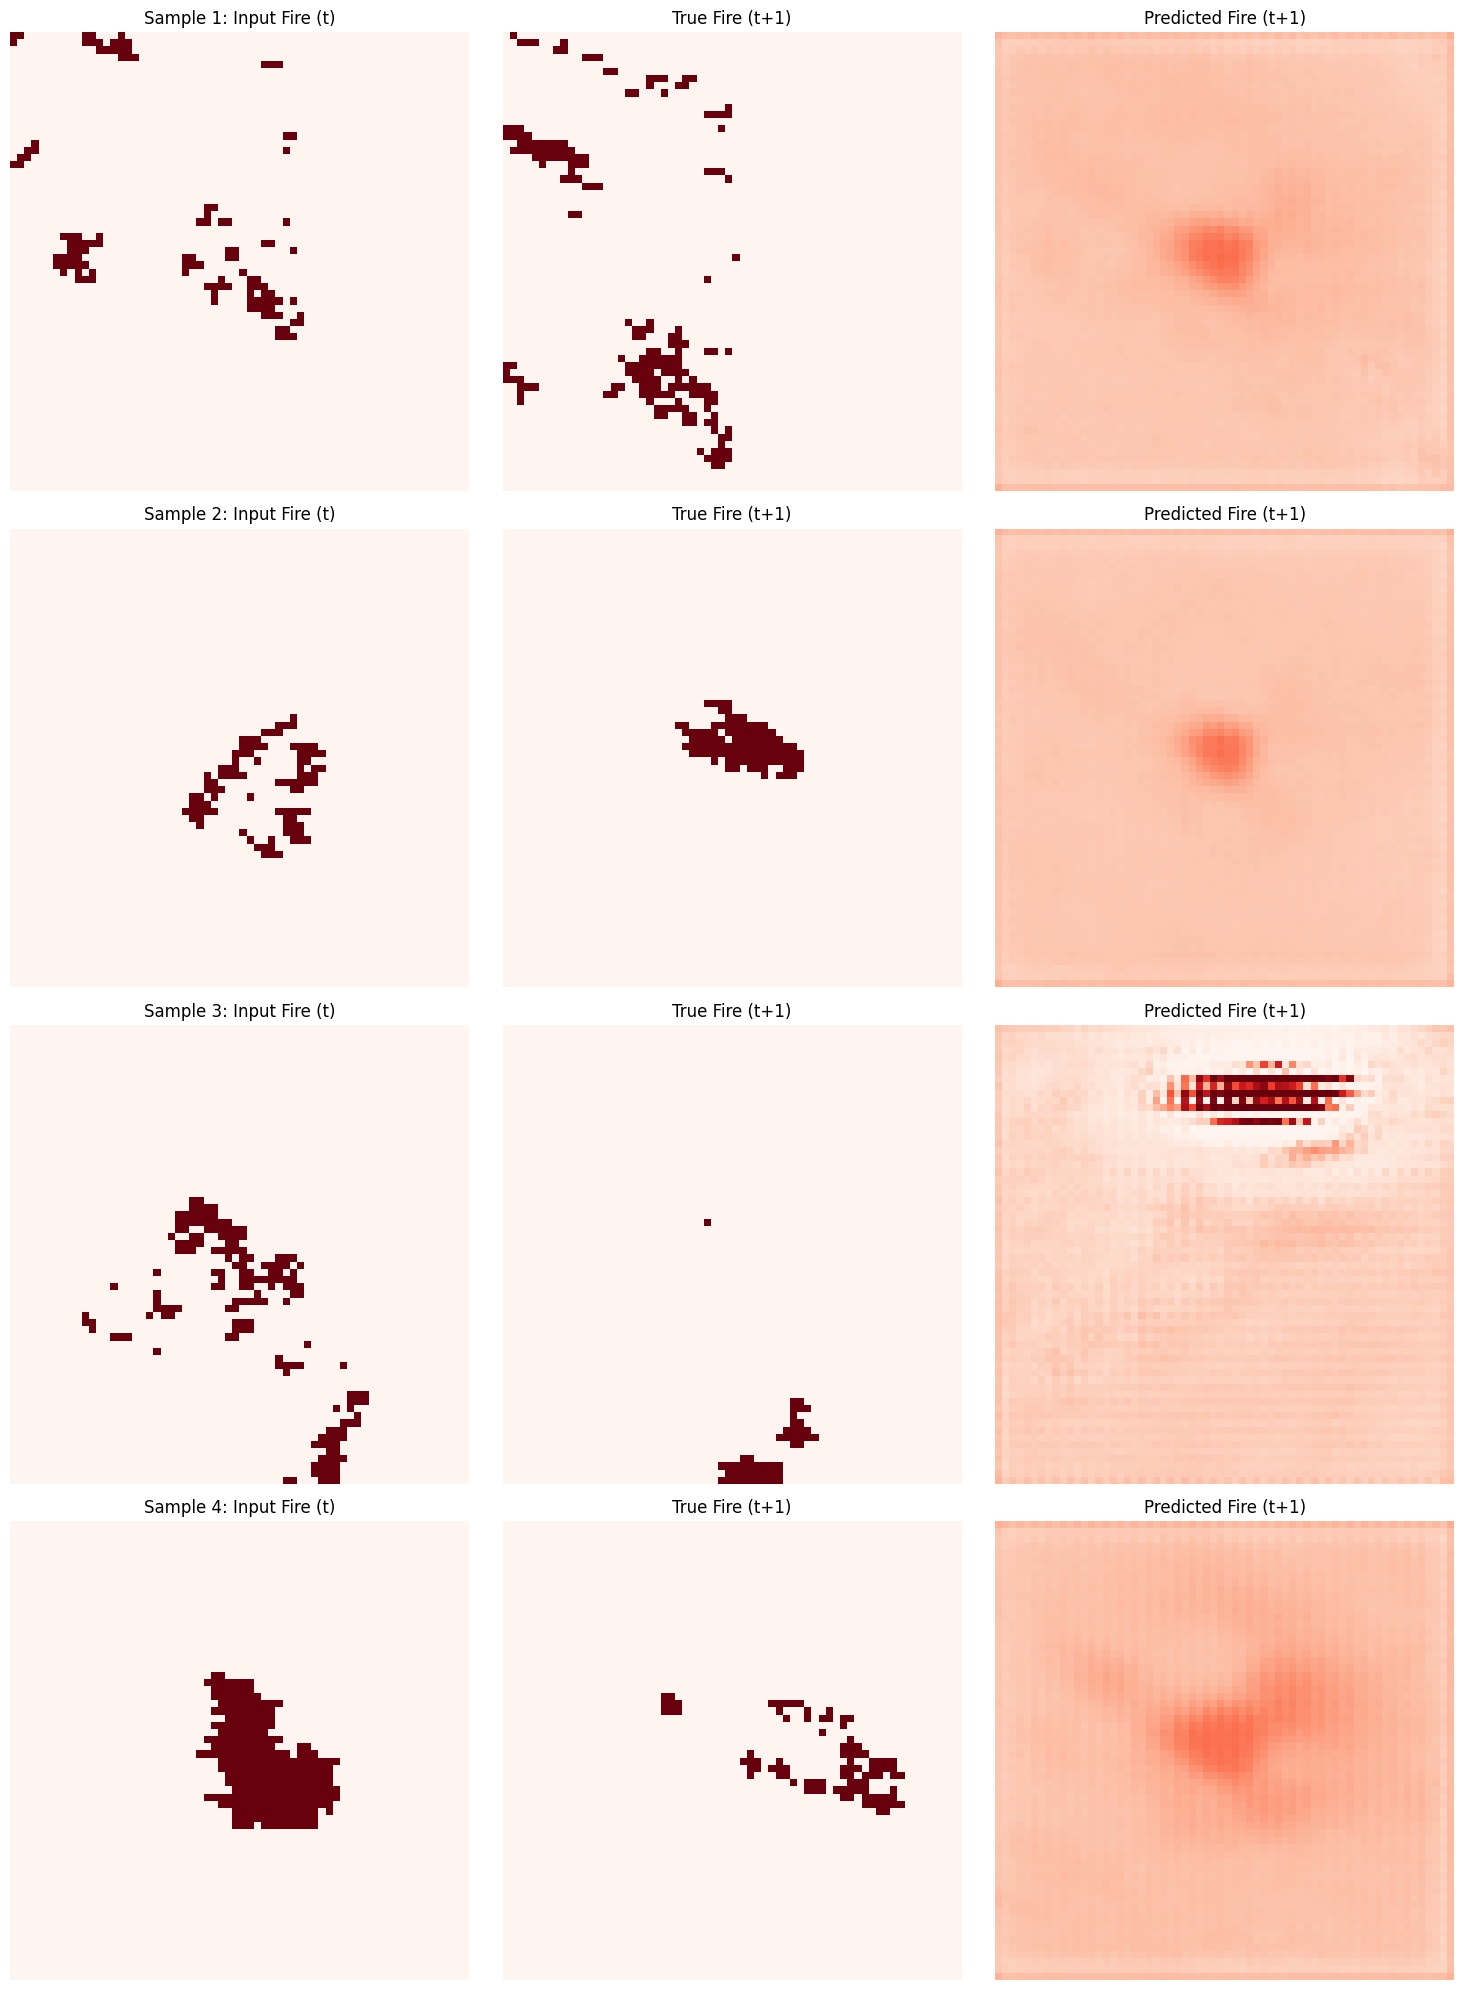


📊 PREDICTION STATISTICS:
🔥 True fire pixels in displayed samples: 437
🎯 Predicted fire pixels (threshold > 0.5): 105
📈 Average prediction confidence: 0.2165
✅ Results for 'TransUNet' appended to 'model_results.txt'


In [6]:
# --- EXECUTION FOR THE COMBINED TIME-SERIES MODEL WITH TRANSUNET ---

# --- MODEL CONFIGURATION ---
model_name = "TransUNet"
checkpoint_file = "transunet_checkpoint.pth"

# Get the number of input channels from a sample item
sample_x, _ = WildfireDataset(data_dir=DATA_DIR, max_sequences=1)[0]
num_input_channels = sample_x.shape[0]

# Define the arguments for the TransUNet model
transunet_args = {
    'in_channels': num_input_channels,
    'out_channels': 1,
    'init_features': 32,
    'vit_patch_size': 1, # Using 1x1 patches from the feature map
    'vit_dim': 256,      # Transformer embedding dimension
    'vit_depth': 4,      # Number of transformer blocks
    'vit_heads': 8,      # Number of attention heads
    'vit_mlp_dim': 512   # Dimension of the MLP inside the transformer
}
print(f"✅ Model configured: {model_name} with {num_input_channels} input channels.")


# 1. Initialize the Dataset (without loading all data into RAM)
print("\n--- Step 1: Preparing Dataset ---")
# First, create a temporary dataset to calculate normalization stats
temp_dataset = WildfireDataset(data_dir=DATA_DIR, num_timesteps=4, max_sequences=100)
normalization_stats = calculate_normalization_stats(temp_dataset, num_samples=100)

# Now, create the final dataset with the normalization stats included
full_dataset = WildfireDataset(
    data_dir=DATA_DIR,
    num_timesteps=4,
    max_sequences=100,
    normalization_stats=normalization_stats
)

# 2. Train the TransUNet model
final_model_transunet = None
cv_results_transunet = []
viz_stats_transunet = None

if len(full_dataset) > 0:
    print(f"\n--- Step 2: Training {model_name} ---")

    final_model_transunet, cv_results_transunet = train_fire_model_cv_pytorch(
        dataset=full_dataset,
        model_class=TransUNet,
        model_args=transunet_args,
        n_splits=3,
        epochs=25,
        batch_size=4, # Keep batch size small due to model complexity
        checkpoint_path=checkpoint_file
    )

    if cv_results_transunet:
        print(f"\n🎉 {model_name} TRAINING COMPLETED!")
    else:
        print(f"❌ {model_name} training failed or was interrupted!")
else:
    print(f"❌ Cannot train model - dataset is empty!")

# 3. Visualization and Saving Results
if final_model_transunet is not None:
    print(f"\n--- Step 3: Generating Visualizations and Saving Results for {model_name} ---")

    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    _, val_indices = list(kfold.split(full_dataset))[-1]

    num_viz_samples = min(4, len(val_indices))
    if num_viz_samples > 0:
        # Get samples directly from the dataset for visualization
        viz_inputs, viz_targets = [], []
        for i in range(num_viz_samples):
            x, y = full_dataset[val_indices[i]]
            viz_inputs.append(np.transpose(x.numpy(), (1, 2, 0))) # H, W, C
            viz_targets.append(np.transpose(y.numpy(), (1, 2, 0)))

        X_test_norm = np.array(viz_inputs)
        y_test_binary = np.array(viz_targets)

        viz_stats_transunet = visualize_fire_predictions_pytorch(
            final_model_transunet, X_test_norm, y_test_binary, num_samples=num_viz_samples, save_path="transunet_predictions.png"
        )
        
        # Save the final results to a text file
        save_results_to_file(model_name, cv_results_transunet, viz_stats_transunet)

    else:
        print("Not enough validation samples to visualize.")

else:
    print(f"\n⚠️ {model_name} model not available for evaluation.")